# Import libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv2
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Preprocessing

## Load images

In [2]:
# Define the path to the dataset directory
dataset_dir = 'new_altered'

# Lists to store image data and labels
image_data = []
labels = []
# person_labels = []


# Iterate through the dataset and load images and labels
for filename in os.listdir(dataset_dir):
    # Extract labels from the filename
    ids = filename.split('_')
    person_id = ids[0]
    hand_id = ids[3]
    finger_id = ids[4]
    # Load the image
    img_path = os.path.join(dataset_dir, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        image_data.append(img)
        labels.append((person_id, hand_id, finger_id))
        # person_labels.append(person_id)

# Now 'image_data' contains the loaded images, and 'labels' contains the corresponding labels

## Data analysis

In [3]:
print(len(image_data))
print(len(labels))
print(labels)

20000
20000
[('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'index'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 'Left', 'little'), ('100', 

In [4]:
# Convert the list of labels to a set to remove duplicates
unique_labels = set(labels)

# The length of the set is the number of unique labels
num_unique_labels = len(unique_labels)

print(f'There are {num_unique_labels} unique labels.')
print(num_unique_labels)

There are 1000 unique labels.
1000


{103: 20000}


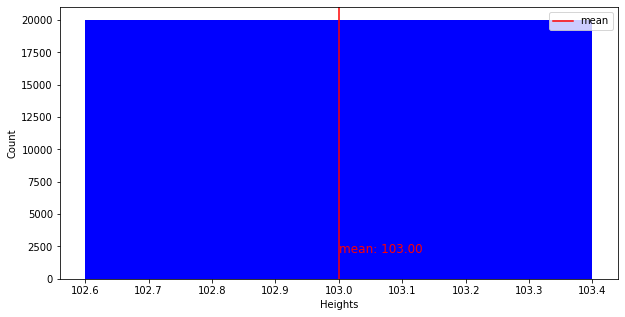

In [5]:
hist = {}
for image in image_data:
    height = image.shape[0]
    hist[height] = hist.get(height, 0) + 1

print(hist)

sum_height = 0
sum_num = 0

for height, num in hist.items():  # Use .items() to iterate over dictionary key-value pairs
    sum_height += height * num
    sum_num += num

mean = sum_height / sum_num

# Create a bar chart for the histogram
plt.figure(figsize=(10, 5))
plt.bar(list(hist.keys()), list(hist.values()), color="b")
plt.xlabel("Heights")
plt.ylabel("Count")

# Plot the mean value as a horizontal line
plt.axvline(x=mean, color='r', label='mean')
plt.text(mean, 2000, f'mean: {mean:.2f}', fontsize=12, color='r')

plt.legend()  # Add a legend to the plot

plt.show()

{96: 20000}


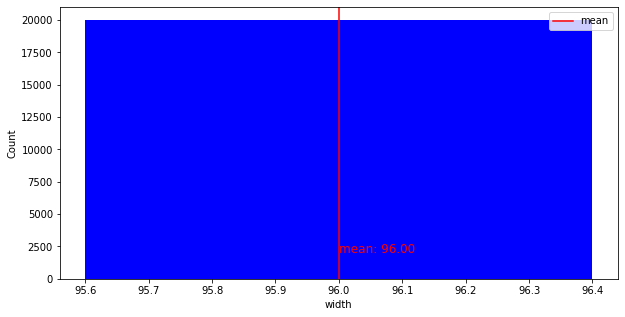

In [6]:
hist = {}
for image in image_data:
    width = image.shape[1]
    hist[width] = hist.get(width, 0) + 1

print(hist)

sum_width = 0
sum_num = 0

for width, num in hist.items():  # Use .items() to iterate over dictionary key-value pairs
    sum_width += width * num
    sum_num += num

mean = sum_width / sum_num

# Create a bar chart for the histogram
plt.figure(figsize=(10, 5))
plt.bar(list(hist.keys()), list(hist.values()), color="b")
plt.xlabel("width")
plt.ylabel("Count")

# Plot the mean value as a horizontal line
plt.axvline(x=mean, color='r', label='mean')
plt.text(mean, 2000, f'mean: {mean:.2f}', fontsize=12, color='r')

plt.legend()  # Add a legend to the plot

plt.show()

Most of the images have fixed size (96, 103) -> Therefore we resize all images to 96 x 103

In [7]:
# resizing all the data to 103X96
for i,image in enumerate(image_data):
    image_data[i] = cv2.resize(image ,(96,103))

## Histogram equalization

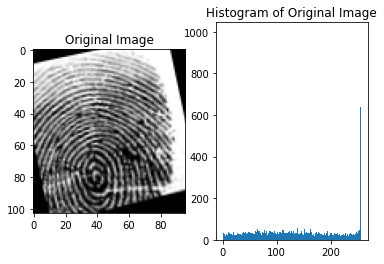

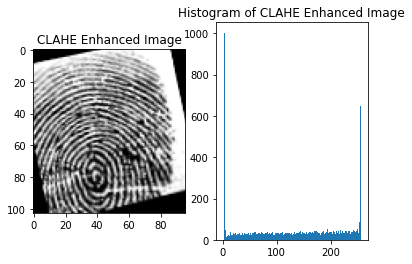

In [8]:
plt.figure()

# Assuming data is your set of images
real_img = image_data[77]  # Change index according to your dataset

# Plot original image and its histogram
plt.subplot(121)
plt.imshow(real_img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.hist(real_img.ravel(), 256, [0, 256])
plt.title('Histogram of Original Image')

plt.show()

# Apply CLAHE to all images in the 'data' set
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
for i in range(len(image_data)):
    new = clahe.apply(image_data[i])
    image_data[i] = new

# Display the results after CLAHE
plt.figure()

# Plot CLAHE-enhanced image and its histogram for the same index
plt.subplot(121)
plt.imshow(image_data[77], cmap='gray')
plt.title('CLAHE Enhanced Image')

plt.subplot(122)
plt.hist(image_data[77].ravel(), 256, [0, 256])
plt.title('Histogram of CLAHE Enhanced Image')

plt.show()

# Model

## SVM

### HOG feature extraction

In [9]:
# Initialize HOG descriptor
hog = cv2.HOGDescriptor()

# Extract features using HOG for each image
hog_features = []
for img in image_data:
    hog_img = cv2.resize(img, (64, 128), interpolation=cv2.INTER_AREA)  # Resize image to a common size for HOG
    features = hog.compute(hog_img)
    hog_features.append(features.flatten())

# Now 'hog_features' contains the extracted HOG features


### Label encoding

In [10]:
# Convert the tuples to strings
string_labels = ['_'.join(map(str, label)) for label in labels]

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Use fit_transform to transform the combined labels into encoded integers
encoded_labels = label_encoder.fit_transform(string_labels)

# Get the counts of each label
label_counts = np.bincount(encoded_labels)

# Print the count of each label
for label, count in enumerate(label_counts):
    print(f"Label {label}: {count} instances")

Label 0: 20 instances
Label 1: 20 instances
Label 2: 20 instances
Label 3: 20 instances
Label 4: 20 instances
Label 5: 20 instances
Label 6: 20 instances
Label 7: 20 instances
Label 8: 20 instances
Label 9: 20 instances
Label 10: 20 instances
Label 11: 20 instances
Label 12: 20 instances
Label 13: 20 instances
Label 14: 20 instances
Label 15: 20 instances
Label 16: 20 instances
Label 17: 20 instances
Label 18: 20 instances
Label 19: 20 instances
Label 20: 20 instances
Label 21: 20 instances
Label 22: 20 instances
Label 23: 20 instances
Label 24: 20 instances
Label 25: 20 instances
Label 26: 20 instances
Label 27: 20 instances
Label 28: 20 instances
Label 29: 20 instances
Label 30: 20 instances
Label 31: 20 instances
Label 32: 20 instances
Label 33: 20 instances
Label 34: 20 instances
Label 35: 20 instances
Label 36: 20 instances
Label 37: 20 instances
Label 38: 20 instances
Label 39: 20 instances
Label 40: 20 instances
Label 41: 20 instances
Label 42: 20 instances
Label 43: 20 instance

In [11]:
features = hog_features  

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Define the parameter grid without 'gamma'
param_grid = {'C': np.arange(0.9, 1.1, 0.1), # np.arange(0.05, 1.05, 0.05)
              'gamma': [0.1, 0.01], # [1, 0.1, 0.01, 0.001]
              'kernel': ['linear']} #'kernel': ['rbf', 'sigmoid', 'linear', 'poly']

# Initialize the SVM classifier
svm = SVC(class_weight='balanced')

# Initialize Stratified K-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with Stratified K-fold
# scoring ở đây nên để là recall/f1 tuy nhiên code lại bị lỗi nếu để thế, ae nghiên cứu fix hộ
# n_jobs = -1 sẽ dùng full cpu, nếu muốn chỉ dùng 2 core, để n_jobs=2
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=skf, n_jobs=3, scoring='accuracy')

# Fit the data to perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

In [ ]:
# Train the SVM model with the best parameters
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Predict on the test set
y_pred = best_svm.predict(X_test)

print(classification_report(y_test,y_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)